---
# Movie Recommendation System Using Collaborative Filtering on the Movies Dataset
### Authors: Zak, Yue
### CP612 - Data Management
### July 18,2025
---

## 1. Load the Datasets

Load the datasets required to build our collaborative filtering movie recommender system. Using the full [Kaggle Movies Dataset](https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset), which contains various files related to user ratings and movie metadata.

### Files used:
- **`ratings.csv`** – Core user-movie ratings file (userId, movieId, rating, timestamp)
- **`movies_metadata.csv`** – Basic movie information (id, title, genres, etc.)

In [20]:
import pandas as pd
import numpy as np

# Load CSV files
ratings = pd.read_csv("ratings.csv")
movies = pd.read_csv("movies_metadata.csv")

print("Ratings shape:", ratings.shape)
print("Movies metadata shape:", movies.shape)

# Clean 'id' column (non-numeric movie IDs)
movies = movies[movies['id'].apply(lambda x: x.isnumeric())].copy()
movies['id'] = movies['id'].astype(int)
movies.rename(columns={'id': 'movieId'}, inplace=True)

Ratings shape: (26024289, 4)
Movies metadata shape: (45466, 24)


C:\Users\Zahaak\AppData\Local\Temp\ipykernel_7484\3766761956.py:6: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movies = pd.read_csv("movies_metadata.csv")


#### Preview datasets

In [21]:
print("\nRatings preview:"); print(); print(ratings.head()); print(); print(ratings.info())


Ratings preview:

   userId  movieId  rating   timestamp
0       1      110     1.0  1425941529
1       1      147     4.5  1425942435
2       1      858     5.0  1425941523
3       1     1221     5.0  1425941546
4       1     1246     5.0  1425941556

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26024289 entries, 0 to 26024288
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 794.2 MB
None


In [22]:
print("\nMovies preview:"); print(); print(movies.head(1)); print(); print(movies.info())


Movies preview:

   adult                              belongs_to_collection    budget  \
0  False  {'id': 10194, 'name': 'Toy Story Collection', ...  30000000   

                                              genres  \
0  [{'id': 16, 'name': 'Animation'}, {'id': 35, '...   

                               homepage  movieId    imdb_id original_language  \
0  http://toystory.disney.com/toy-story      862  tt0114709                en   

  original_title                                           overview  ...  \
0      Toy Story  Led by Woody, Andy's toys live happily in his ...  ...   

  release_date      revenue runtime                          spoken_languages  \
0   1995-10-30  373554033.0    81.0  [{'iso_639_1': 'en', 'name': 'English'}]   

     status  tagline      title  video vote_average vote_count  
0  Released      NaN  Toy Story  False          7.7     5415.0  

[1 rows x 24 columns]

<class 'pandas.core.frame.DataFrame'>
Index: 45463 entries, 0 to 45465
Data columns (tota

## Data Cleaning

In [23]:
# Merge ratings with cleaned movies metadata on movieId
merged_data = pd.merge(ratings, movies, on='movieId')

# Show shape and preview
print("Merged data shape:", merged_data.shape)
print(merged_data[['userId', 'movieId', 'rating', 'title']].head())

Merged data shape: (11437637, 27)
   userId  movieId  rating                 title
0       1      110     1.0     Three Colors: Red
1       1      147     4.5         The 400 Blows
2       1      858     5.0  Sleepless in Seattle
3       1     1246     5.0          Rocky Balboa
4       1     1968     4.0         Fools Rush In


In [24]:
# Keep only relevant columns
merged_data = merged_data[['userId', 'movieId', 'title', 'rating']]

# Confirm structure
print("Trimmed merged_data shape:", merged_data.shape)
print(merged_data.head())

Trimmed merged_data shape: (11437637, 4)
   userId  movieId                 title  rating
0       1      110     Three Colors: Red     1.0
1       1      147         The 400 Blows     4.5
2       1      858  Sleepless in Seattle     5.0
3       1     1246          Rocky Balboa     5.0
4       1     1968         Fools Rush In     4.0


#### Filter for Active Users & Popular Movies

Collaborative Filtering works better when:
- Users have rated enough movies
- Movies have been rated by enough users

Otherwise, the user-item matrix becomes too sparse, making similarity computations unreliable.

For this expirement:
- Keep users who have rated at least 25 movies
- Keep movies that have been rated by at least 100 users

In [25]:
# Set thresholds
MIN_USER_RATINGS = 50
MIN_MOVIE_RATINGS = 100

# Filter users with enough ratings
user_counts = merged_data['userId'].value_counts()
active_users = user_counts[user_counts >= MIN_USER_RATINGS].index
filtered_data = merged_data[merged_data['userId'].isin(active_users)]

# Filter movies with enough ratings
movie_counts = filtered_data['movieId'].value_counts()
popular_movies = movie_counts[movie_counts >= MIN_MOVIE_RATINGS].index
filtered_data = filtered_data[filtered_data['movieId'].isin(popular_movies)]

# Show shape and preview
print("Filtered data shape:", filtered_data.shape)
print(filtered_data.head())

Filtered data shape: (8268572, 4)
    userId  movieId                               title  rating
91       8      170                       28 Days Later     3.0
92       8      318            The Million Dollar Hotel     5.0
93       8      553                            Dogville     4.0
94       8      585                      Monsters, Inc.     2.0
95       8      647  Final Fantasy VII: Advent Children     4.0


In [33]:
filtered_data.isnull().sum()

userId     0
movieId    0
title      0
rating     0
dtype: int64

## Building User-Item Matrix

Create a matrix where:
- Rows = users
- Columns = movie titles
- Values = ratings

This matrix is essential for both user-based and item-based collaborative filtering.

In [26]:
# Create the user-item matrix
user_item_matrix = filtered_data.pivot_table(
    index='userId',
    columns='title',
    values='rating'
)

# Show dimensions and preview
print("User-Item Matrix shape:", user_item_matrix.shape)
user_item_matrix.head()

User-Item Matrix shape: (61472, 2924)


title,!Women Art Revolution,$5 a Day,'Gator Bait,'Twas the Night Before Christmas,...And the Pursuit of Happiness,10 Items or Less,10 Things I Hate About You,"10,000 BC",11'09''01 - September 11,12 Angry Men,...,Zombie Flesh Eaters,Zombie Holocaust,Zozo,eXistenZ,xXx,¡A volar joven!,À nos amours,Ödipussi,Şaban Oğlu Şaban,Šíleně smutná princezna
userId,,,,,,,,,,,,,,,,,,,,,
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## User-Based Collaborative Filtering

In UBCF, recommend movies to a user based on what similar users have rated highly.

Overview:
- Compute user-user similarity matrix
- Define a function to predict rating for a user and movie using k-nearest neighbors
- Define a function to recommend top-N movies the user hasn’t rated yet

In [27]:
from sklearn.metrics.pairwise import cosine_similarity

# Fill NaNs with 0 for similarity calculation
user_item_filled = user_item_matrix.fillna(0)

# Compute cosine similarity between users
user_similarity = cosine_similarity(user_item_filled)

# Store as a DataFrame for easier access
user_similarity_df = pd.DataFrame(
    user_similarity,
    index=user_item_filled.index,
    columns=user_item_filled.index
)

# Show top-left corner
print("User-user similarity matrix (sample):")
user_similarity_df.iloc[:5, :5]


User-user similarity matrix (sample):


userId,8,11,12,15,16
userId,,,,,
8,1.000000,0.099153,0.051247,0.077278,0.111632
11,0.099153,1.000000,0.132219,0.174500,0.159887
12,0.051247,0.132219,1.000000,0.152326,0.105079
15,0.077278,0.174500,0.152326,1.000000,0.216765
16,0.111632,0.159887,0.105079,0.216765,1.000000


In [36]:
filtered_data.shape[0]

merged_users = merged_data['userId'].nunique()
print("Unique users after merging:", merged_users)

Unique users after merging: 265917


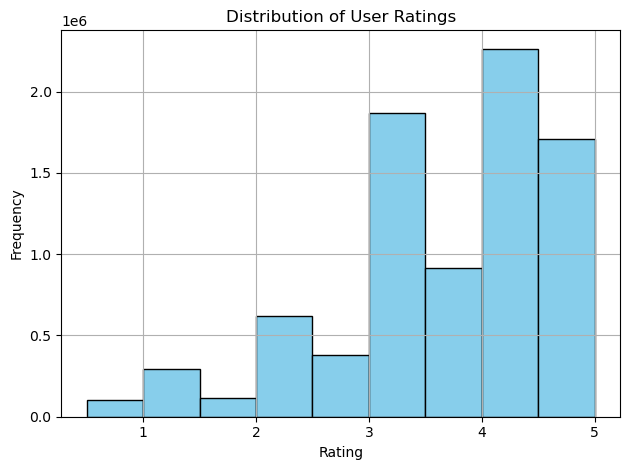

In [37]:
filtered_data['rating'].hist(bins=9, edgecolor='black', color='skyblue')
plt.title("Distribution of User Ratings")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig("rating_distribution.png")
plt.show()

#### Predict a User’s Rating for a Movie (using Top‑k Similar Users)
Define a function to predict how much a user would rate a movie they haven’t rated yet, based on the ratings from their k most similar users.

Algorithm:
- Find k most similar users to the target user
- Among those k users, filter out ones who haven't rated the movie
- Use a weighted average of their ratings, weighted by similarity

In [28]:
def predict_rating(user_id, movie_title, k=5):
    # Safety check: is the user and movie in the matrix?
    if movie_title not in user_item_matrix.columns or user_id not in user_item_matrix.index:
        return np.nan

    # Get similarity scores for the user
    sims = user_similarity_df[user_id]

    # Get ratings for the movie from all users
    movie_ratings = user_item_matrix[movie_title]

    # Keep only users who rated the movie
    valid_users = movie_ratings[movie_ratings.notna()].index
    sims = sims[valid_users]
    movie_ratings = movie_ratings[valid_users]

    # Get top-k similar users
    top_k_users = sims.sort_values(ascending=False)[:k]
    top_k_ratings = movie_ratings[top_k_users.index]

    # If none of the neighbors rated the movie, fallback
    if top_k_ratings.empty or top_k_users.sum() == 0:
        return user_item_matrix.loc[user_id].mean()  # fallback: user's mean rating

    # Weighted average
    return np.dot(top_k_ratings, top_k_users) / top_k_users.sum()

In [29]:
# Pick a real user from the matrix
sample_user = user_item_matrix.index[0]

# Find a movie they haven't rated
unrated_movies = user_item_matrix.columns[user_item_matrix.loc[sample_user].isna()]
test_movie = unrated_movies[0]

# Predict the rating
predicted = predict_rating(sample_user, test_movie, k=5)
print(f"Predicted rating for User {sample_user} on '{test_movie}': {predicted:.2f}")

Predicted rating for User 8 on '!Women Art Revolution': 2.31


In [30]:
def recommend_movies(user_id, k=5, n=5):
    if user_id not in user_item_matrix.index:
        return []

    # Get all movies the user hasn't rated
    unrated_movies = user_item_matrix.columns[user_item_matrix.loc[user_id].isna()]
    
    predictions = []

    for movie in unrated_movies:
        pred_rating = predict_rating(user_id, movie, k)
        if not np.isnan(pred_rating):
            predictions.append((movie, pred_rating))

    # Sort by predicted rating
    predictions.sort(key=lambda x: x[1], reverse=True)

    # Return top-N
    return predictions[:n]

In [31]:
sample_user = user_item_matrix.index[0]
recommendations = recommend_movies(sample_user, k=5, n=5)

print(f"\nTop 5 recommendations for User {sample_user}:\n")
for title, score in recommendations:
    print(f"{title}: predicted rating = {score:.2f}")


Top 5 recommendations for User 8:

Ronin: predicted rating = 4.90
Stranger Than Fiction: predicted rating = 4.80
The 39 Steps: predicted rating = 4.80
The Bank Job: predicted rating = 4.71
Charlie's Angels: predicted rating = 4.70


In [49]:
sample_user = user_item_matrix.index[1]
recommendations = recommend_movies(sample_user, k=5, n=5)

print(f"\nTop 5 recommendations for User {sample_user}:\n")
for title, score in recommendations:
    print(f"{title}: predicted rating = {score:.2f}")


Top 5 recommendations for User 11:

Cousin, Cousine: predicted rating = 4.80
Salvatore Giuliano: predicted rating = 4.71
Yamakasi: predicted rating = 4.71
Get Shorty: predicted rating = 4.70
The Prisoner of Zenda: predicted rating = 4.70


In [50]:
sample_user = user_item_matrix.index[2]
recommendations = recommend_movies(sample_user, k=5, n=5)

print(f"\nTop 5 recommendations for User {sample_user}:\n")
for title, score in recommendations:
    print(f"{title}: predicted rating = {score:.2f}")


Top 5 recommendations for User 12:

The Good Shepherd: predicted rating = 5.00
Blondie Knows Best: predicted rating = 4.81
Flags of Our Fathers: predicted rating = 4.81
Rush Hour: predicted rating = 4.81
Saving Grace: predicted rating = 4.80


Cosine Similarity: 0.9989


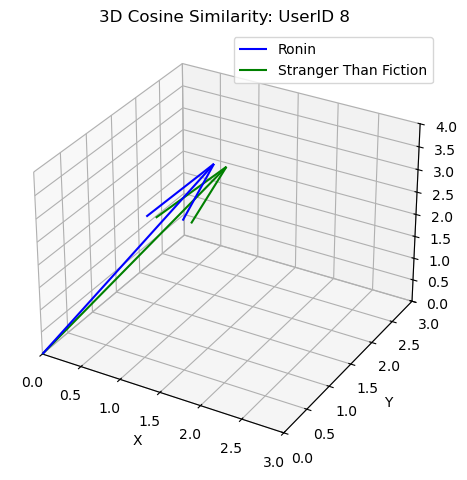

In [42]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define 3D vectors
ronin_vector = np.array([1, 2, 3])
stranger_vector = np.array([1.1, 2.1, 2.9])  # Very close direction

# Cosine similarity
vecs = np.array([ronin_vector, stranger_vector])
cos_sim = cosine_similarity(vecs)[0, 1]
print(f"Cosine Similarity: {cos_sim:.4f}")

# Plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Origin
origin = [0, 0, 0]

# Plot vectors
ax.quiver(*origin, *ronin_vector, color='blue', label='Ronin')
ax.quiver(*origin, *stranger_vector, color='green', label='Stranger Than Fiction')

# Axis limits for better view
ax.set_xlim([0, 3])
ax.set_ylim([0, 3])
ax.set_zlim([0, 4])

# Labels and legend
ax.set_title('3D Cosine Similarity: UserID 8')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()

plt.tight_layout()
plt.show()

### Evaluation (Offline)
You asked earlier:

How do I know if these predictions are good without asking the user?

The answer is:

Offline Evaluation with RMSE (Root Mean Squared Error)
Evaluation Strategy: Leave-One-Out (LOO)
For each user:

Hold out one real rating (as test)

Predict it using your recommender (based on remaining ratings)

Compare the prediction to the true rating

Repeat for many users → calculate average error

In [11]:
import random
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

# Copy original matrix to avoid damaging it
eval_matrix = user_item_matrix.copy()

# Store held-out (test) data
test_data = []

# For each user, randomly remove one rating
for user in eval_matrix.index:
    user_ratings = eval_matrix.loc[user].dropna()
    if len(user_ratings) > 5:
        movie = random.choice(user_ratings.index.tolist())
        rating = user_ratings[movie]
        eval_matrix.at[user, movie] = np.nan  # remove from matrix
        test_data.append((user, movie, rating))

In [12]:
# Recompute similarity from modified matrix
eval_matrix_filled = eval_matrix.fillna(0)
user_sim_eval = cosine_similarity(eval_matrix_filled)

user_sim_df_eval = pd.DataFrame(
    user_sim_eval,
    index=eval_matrix.index,
    columns=eval_matrix.index
)

In [13]:
def predict_for_eval(user_id, movie_title, k=5):
    if movie_title not in eval_matrix.columns or user_id not in eval_matrix.index:
        return np.nan

    sims = user_sim_df_eval[user_id]
    movie_ratings = eval_matrix[movie_title]

    valid_users = movie_ratings[movie_ratings.notna()].index
    sims = sims[valid_users]
    movie_ratings = movie_ratings[valid_users]

    top_k = sims.sort_values(ascending=False)[:k]
    top_k_ratings = movie_ratings[top_k.index]

    if top_k_ratings.empty or top_k.sum() == 0:
        return eval_matrix.loc[user_id].mean()  # fallback

    return np.dot(top_k_ratings, top_k) / top_k.sum()

In [15]:
actual = []
predicted = []

# Limit to first 500–1000 samples for speed
for user, movie, true_rating in tqdm(test_data[:1000]):
    pred = predict_for_eval(user, movie, k=5)
    if not np.isnan(pred):
        actual.append(true_rating)
        predicted.append(pred)

from sklearn.metrics import mean_squared_error
import math

mse = mean_squared_error(actual, predicted)
rmse = math.sqrt(mse)

print(f"\nUser-Based CF RMSE on {len(actual)} samples: {rmse:.4f}")


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 352.96it/s]


User-Based CF RMSE on 1000 samples: 0.9439


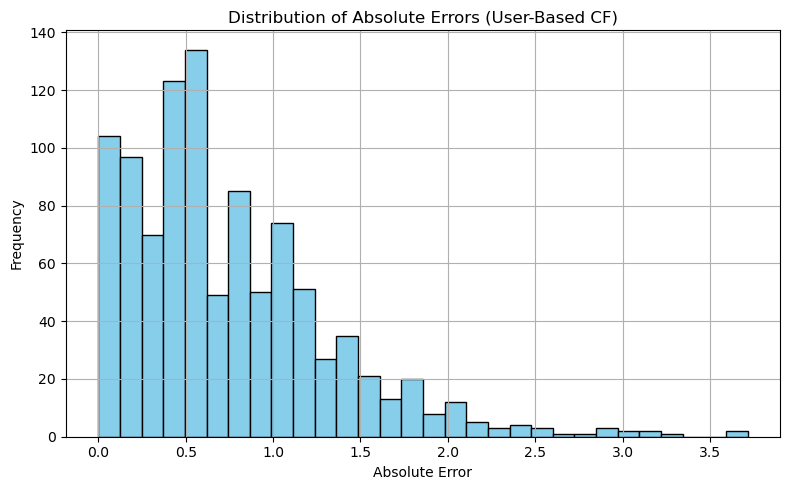

In [16]:
import matplotlib.pyplot as plt

# OPTIONAL: only if you saved individual errors
errors = [abs(a - p) for a, p in zip(actual, predicted)]

plt.figure(figsize=(8, 5))
plt.hist(errors, bins=30, edgecolor='black', color='skyblue')
plt.title("Distribution of Absolute Errors (User-Based CF)")
plt.xlabel("Absolute Error")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

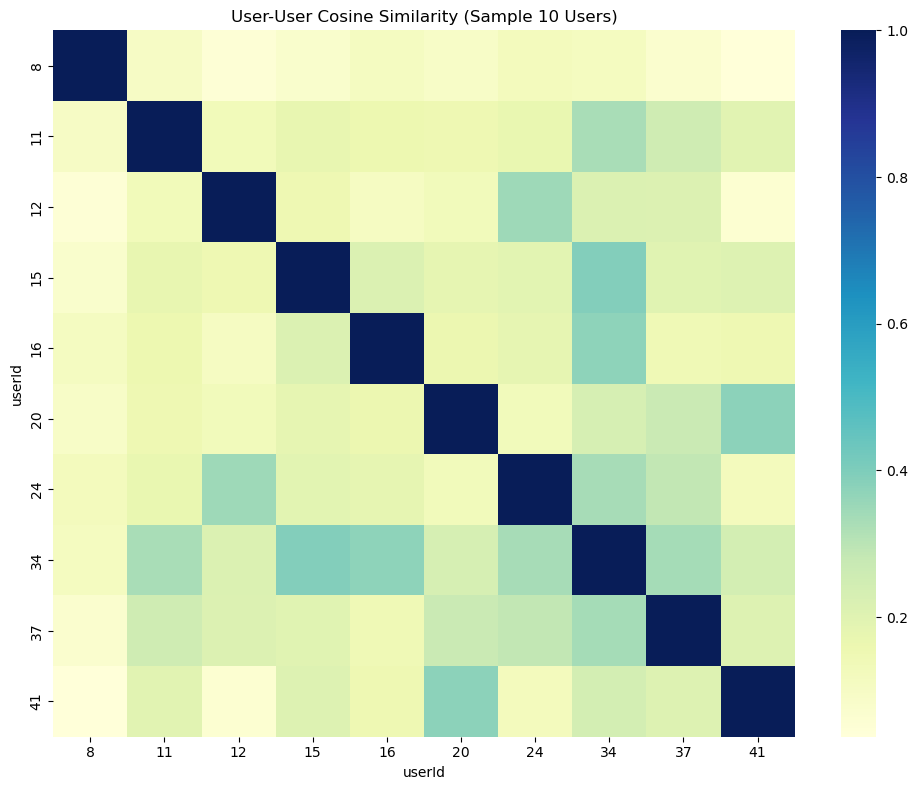

In [44]:
import seaborn as sns

# Select a 20x20 slice for visibility
sample_users = user_similarity_df.iloc[:10, :10]

plt.figure(figsize=(10, 8))
sns.heatmap(sample_users, cmap="YlGnBu", annot=False)
plt.title("User-User Cosine Similarity (Sample 10 Users)")
plt.tight_layout()
plt.show()


C:\Users\Zahaak\AppData\Local\Temp\ipykernel_7484\3598575679.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scores, y=titles, palette="viridis")


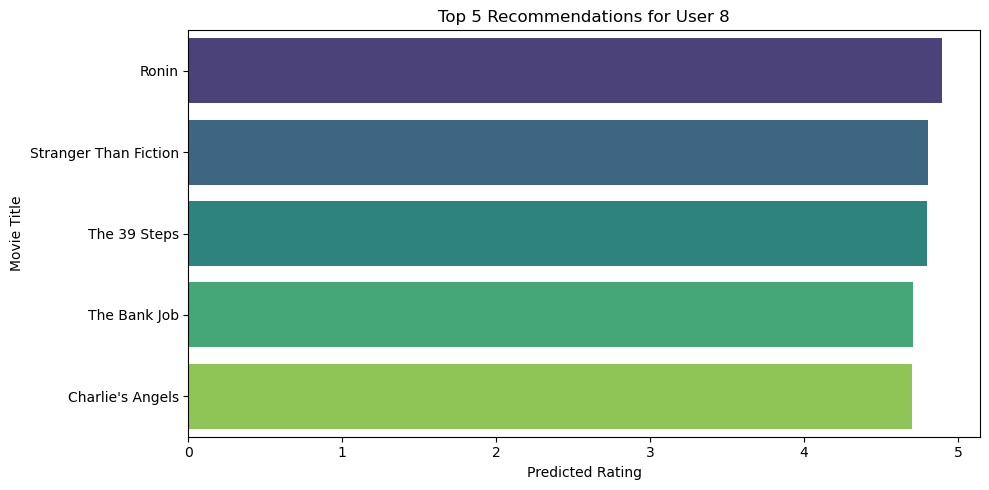

In [46]:
# Get top 5 recommendations for one user
sample_user = user_item_matrix.index[0]
recommendations = recommend_movies(sample_user, k=5, n=5)

# Unzip for plotting
titles, scores = zip(*recommendations)

plt.figure(figsize=(10, 5))
sns.barplot(x=scores, y=titles, palette="viridis")
plt.xlabel("Predicted Rating")
plt.ylabel("Movie Title")
plt.title(f"Top 5 Recommendations for User {sample_user}")
plt.tight_layout()
plt.show()

In [48]:
import numpy as np
import random
from sklearn.metrics import ndcg_score

K = 5  # Top-K
num_users_to_test = 100  # Keep small for speed

# Helper: check if predicted Top-K includes the held-out relevant item
def evaluate_topk(user_id, held_out_movie_id, k=K):
    predictions = []
    for movie_id in user_item_matrix.columns:
        if pd.isna(user_item_matrix.loc[user_id, movie_id]):
            pred = predict_rating(user_id, movie_id, k=5)
            if not np.isnan(pred):
                predictions.append((movie_id, pred))

    # Sort by predicted score
    predictions = sorted(predictions, key=lambda x: x[1], reverse=True)
    top_k = [m[0] for m in predictions[:k]]

    precision = int(held_out_movie_id in top_k) / k
    recall = int(held_out_movie_id in top_k) / 1  # One held-out item

    # For NDCG, binary relevance vector
    y_true = [1 if m[0] == held_out_movie_id else 0 for m in predictions[:k]]
    y_score = [m[1] for m in predictions[:k]]
    ndcg = ndcg_score([y_true], [y_score])

    return precision, recall, ndcg

# Sample users with at least 10 rated items (so we can hold 1 out)
eligible_users = user_item_matrix.dropna(thresh=10).index.tolist()
random.shuffle(eligible_users)

# Run evaluation
precisions, recalls, ndcgs = [], [], []

for user_id in eligible_users[:num_users_to_test]:
    user_ratings = user_item_matrix.loc[user_id].dropna()
    relevant_items = user_ratings[user_ratings >= 4.0].index.tolist()

    if len(relevant_items) < 2:
        continue  # Need at least 2 to hold 1 out

    held_out = random.choice(relevant_items)
    user_item_matrix.loc[user_id, held_out] = np.nan  # Hide it temporarily

    try:
        p, r, n = evaluate_topk(user_id, held_out)
        precisions.append(p)
        recalls.append(r)
        ndcgs.append(n)
    except:
        continue

    user_item_matrix.loc[user_id, held_out] = user_ratings[held_out]  # Restore

# Final average metrics
print(f"Precision@{K}: {np.mean(precisions):.4f}")
print(f"Recall@{K}: {np.mean(recalls):.4f}")
print(f"NDCG@{K}: {np.mean(ndcgs):.4f}")


Precision@5: 0.0180
Recall@5: 0.0900
NDCG@5: 0.0691


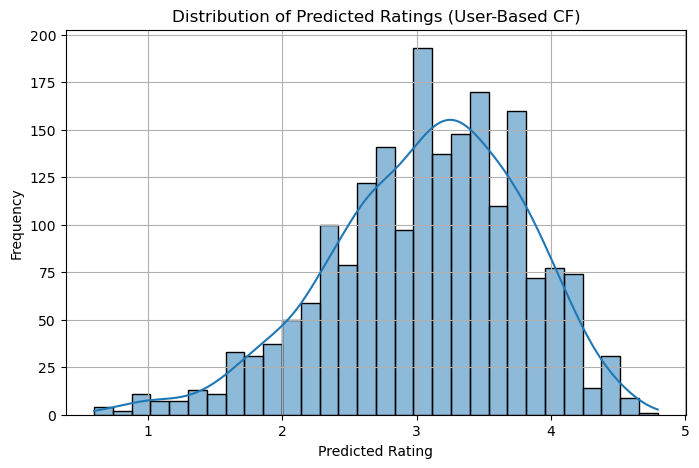

In [51]:

sample_users = random.sample(user_item_matrix.index.tolist(), 100)
predicted_ratings = []

for user_id in sample_users:
    user_rated_movies = user_item_matrix.loc[user_id].dropna().index.tolist()
    unrated_movies = [m for m in user_item_matrix.columns if m not in user_rated_movies]
    sample_movies = random.sample(unrated_movies, 20)

    for movie_id in sample_movies:
        try:
            pred = predict_rating(user_id, movie_id, k=5)
            if not np.isnan(pred):
                predicted_ratings.append(pred)
        except:
            continue

# Plot distribution
plt.figure(figsize=(8, 5))
sns.histplot(predicted_ratings, bins=30, kde=True)
plt.title("Distribution of Predicted Ratings (User-Based CF)")
plt.xlabel("Predicted Rating")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()